In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image as kp_image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time


In [ ]:
# Helper functions to load, preprocess, and deprocess images
def load_and_process_img(path, max_dim=768):
    img = Image.open(path)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def show_img(img, title=None):
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


Please upload your Content Image:


Saving messi.jpeg to messi.jpeg
Please upload your Style Image:


Saving starrynight.jpeg to starrynight.jpeg


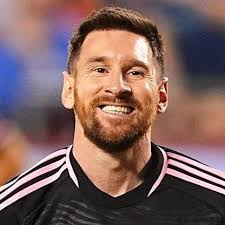

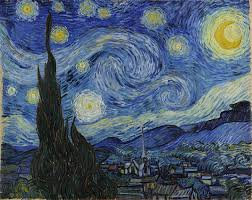

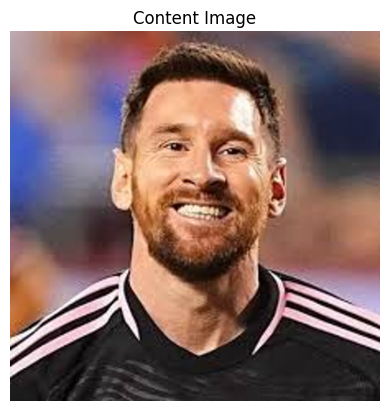

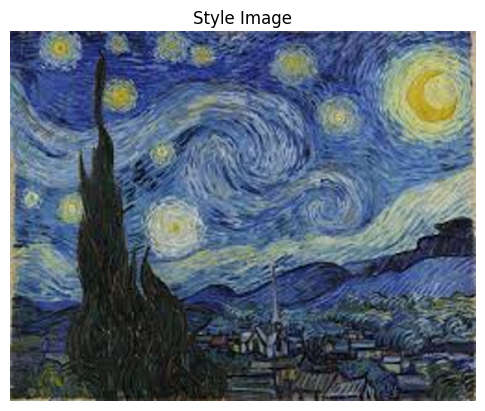

In [ ]:
# Cell 3: Upload content and style images (for Google Colab)

from google.colab import files
from IPython.display import Image as IPImage, display

print("Please upload your Content Image:")
uploaded_content = files.upload()
content_path = list(uploaded_content.keys())[0]

print("Please upload your Style Image:")
uploaded_style = files.upload()
style_path = list(uploaded_style.keys())[0]

# Load and process the uploaded images
content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path)

# Display the uploaded images
display(IPImage(filename=content_path))
display(IPImage(filename=style_path))

show_img(np.squeeze(deprocess_img(content_image.copy())), "Content Image")
show_img(np.squeeze(deprocess_img(style_image.copy())), "Style Image")


In [ ]:
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

print("Content layers:", content_layers)
print("Style layers:", style_layers)


Content layers: ['block5_conv2']
Style layers: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [ ]:
def vgg_model(layer_names):
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = models.Model([vgg.input], outputs)
    return model

extractor = vgg_model(style_layers + content_layers)
extractor.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,304,768 (58.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,304,768 (58.38 MB)

In [ ]:
def gram_matrix(input_tensor):
    x = tf.transpose(input_tensor, (0, 3, 1, 2))
    features = tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], -1))
    gram = tf.matmul(features, features, transpose_b=True)
    return gram / tf.cast(tf.shape(x)[1]*tf.shape(x)[2]*tf.shape(x)[3], tf.float32)

def get_feature_representations(model, content_img, style_img):
    content_outputs = model(content_img)
    style_outputs = model(style_img)

    style_features = [style_layer for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer for content_layer in style_outputs[num_style_layers:]]

    style_grams = [gram_matrix(style_feature) for style_feature in style_features]
    return style_grams, content_features


In [ ]:
style_targets, content_targets = get_feature_representations(extractor, style_image, content_image)

# Initialize generated image as a variable
generated_image = tf.Variable(content_image, dtype=tf.float32)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 610, 768, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 768, 768, 3))
  warnings.warn(msg)


In [ ]:
style_weight = 0.01
content_weight = 1000
total_variation_weight = 30

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_gram, comb_style in zip(gram_style_features, style_output_features):
        gram = gram_matrix(comb_style)
        style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram - target_gram))

    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * tf.reduce_mean(tf.square(comb_content - target_content))

    style_score *= style_weight
    content_score *= content_weight
    tv_loss = total_variation_weight * tf.reduce_sum(tf.image.total_variation(init_image))

    loss = style_score + content_score + tv_loss
    return loss, style_score, content_score, tv_loss


In [ ]:
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
epochs = 50
steps_per_epoch = 100

best_loss = float('inf')
best_img = None

cfg = {
    'model': extractor,
    'loss_weights': (style_weight, content_weight),
    'init_image': generated_image,
    'gram_style_features': style_targets,
    'content_features': content_targets
}

start = time.time()
step = 0

for i in range(epochs):
    for j in range(steps_per_epoch):
        step += 1
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score, tv_loss = all_loss
        optimizer.apply_gradients([(grads, generated_image)])
        generated_image.assign(tf.clip_by_value(generated_image, -103.939, 255.0-103.939))

        if loss < best_loss:
            best_loss = loss
            best_img = generated_image.numpy()

        if step % 50 == 0:
            print(f"Step {step}: total={loss.numpy():.4e}, style={style_score.numpy():.4e}, content={content_score.numpy():.4e}")

end = time.time()
print("Total time:", end - start, "seconds")


Step 50: total=3.0974e+08, style=2.0056e+00, content=9.8294e+03
Step 100: total=3.0966e+08, style=2.0050e+00, content=9.7291e+03
Step 150: total=3.0958e+08, style=2.0045e+00, content=9.6317e+03
Step 200: total=3.0950e+08, style=2.0041e+00, content=9.5370e+03
Step 250: total=3.0942e+08, style=2.0039e+00, content=9.4450e+03
Step 300: total=3.0934e+08, style=2.0037e+00, content=9.3553e+03
Step 350: total=3.0925e+08, style=2.0037e+00, content=9.2680e+03
Step 400: total=3.0917e+08, style=2.0038e+00, content=9.1830e+03
Step 450: total=3.0909e+08, style=2.0040e+00, content=9.1001e+03
Step 500: total=3.0901e+08, style=2.0042e+00, content=9.0192e+03
Step 550: total=3.0893e+08, style=2.0045e+00, content=8.9403e+03
Step 600: total=3.0885e+08, style=2.0049e+00, content=8.8632e+03
Step 650: total=3.0877e+08, style=2.0053e+00, content=8.7879e+03
Step 700: total=3.0869e+08, style=2.0059e+00, content=8.7141e+03
Step 750: total=3.0861e+08, style=2.0064e+00, content=8.6420e+03
Step 800: total=3.0853e+08

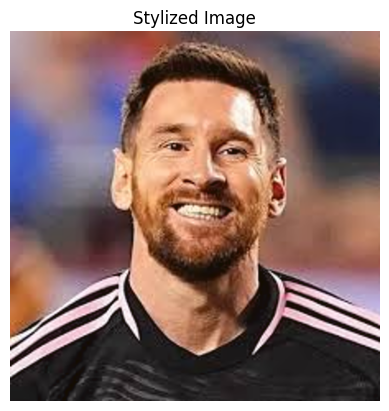

Stylized image saved as stylized_output.png


In [ ]:
final_img = deprocess_img(best_img)
show_img(final_img, "Stylized Image")

# Save the result
Image.fromarray(final_img).save("stylized_output.png")
print("Stylized image saved as stylized_output.png")
